## Replication guide for "Higher-order Learning" (Evdokimov and Garfagnini, 2021)

-----

This notebook contains the Python code for replicating all the simulations and analysis in Evdokimov and Garfagnini (2021). The headings are organized by figures and tables in the order they appear in the paper.

-----

## Figure 1

Figure 1 is used in the text as an illustration of **Prediction 1** that higher-order beliefs are closer to the prior when information is private. We first derive the players' beliefs in the public treatment (which are identical for all player types), and then derive higher-order beliefs with private information.

### Beliefs in the public treatment

Let $P_1(Orange|n, t)$ denote the probability assigned to the orange state by a Bayesian player, conditional on the number of orange balls $n$ observed in period $t$. This value is computed in the code below using the function `bayes(num_balls,period)`.

We assume in the simulations below that orange is the correct state, so that $P_1(Orange|n, t)$ represents the **normalized first-order belief**. 

The expected value of $P_1(Orange|n, t)$ in every period $t$ can be obtained as:
$$
\sum_{n=1}^t P_1(Orange|n, t) \cdot f(n; Orange, t),
$$
where $f(n; Orange, t)={t \choose n} (2/3)^n \cdot (1/3)^{t-n}$ is the probablity of observing $n$ of orange balls in period $t$, obtained from the Binomial distribution for the orange state. 

### Higher-order beliefs in the private treartment
 
In the private treatment, Player $k$'s expectation of the probability assigned by Player $k-1$ to the state being orange, conditional on the number of orange balls $n$ observed in period $t$, is given by:

\begin{align*}
P_{k}(Orange|n,t)&=P_1(Orange|n,t)\cdot \sum_{n'=1}^t P_{k-1}(Orange|n', t)\cdot f(n'; Orange, t) + \\
&+[1-P_1(Orange|n,t)]\cdot \sum P_{k-1}(Orange|n', t)\cdot f(n'; Purple, t)
\end{align*}

I.e., Player $k$ first forms a posterior belief about the state. For each possible state, she computes the expectation of Player $k-1$'s beliefs over all possible numbers $n'$ of orange balls the Player $k-1$ might observe, using the binomial distribution for that state. This value is computed in the code below using the function `bayes2(num_balls,period)` for Player 2 and `bayes3(num_balls,period)` for Player 3.

The expected value of $P_k(Orange|n, t)$ in every period $t$ can be obtained as:
$$
\sum_{n=1}^t P_k(Orange|n, t) \cdot f(n; Orange, t),
$$
similar to its counterpart for Player 1 in the description above.

-----

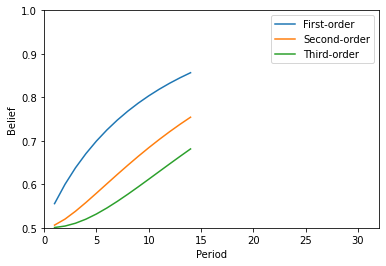

In [1]:
# import packages
from scipy.stats import binom
import matplotlib.pyplot as plt


# set the number of periods 

# change the right end point of the range to generate more predictions 
# (i.e., to 6 for 5 periods, 11 for 10 periods, etc.)
periods = list(range(1,15))


# define bayes' rule
def bayes(num_balls, period):
    return (((2/3) ** num_balls) * ((1/3) ** (period-num_balls))) \
    /(((2 / 3) ** num_balls) * ((1 / 3) ** (period - num_balls))+((1 / 3) ** num_balls) \
      * ((2 / 3) ** (period - num_balls)))


# initialize public beliefs list
beliefs_public = list()


# loop through periods and for each period compute expected first-order belief
for period in periods:
    expected_belief = 0
    for num_balls in range(period+1):
        expected_belief += bayes(num_balls, period) * binom.pmf(num_balls,period,2/3)
    beliefs_public.append(expected_belief)


# define function for private second-order beliefs computed using bayes' rule
def bayes2(num_balls, period):
    # expectation over histories for each state
    sum1 = 0
    sum2 = 0
    for num in range(period+1):
        sum1 += bayes(num, period) * binom.pmf(num, period, 2 / 3)
        sum2 += bayes(num, period) * binom.pmf(num, period, 1 / 3)
    # expectation over states
    return bayes(num_balls, period) * sum1 \
           + (1 - bayes(num_balls, period)) * sum2


# initialize the list of private second-order beliefs
beliefs_private2 = list()


# loop through periods and for each period compute expected private second-order belief
for period in periods:
    expected_belief2 = 0
    for num_balls in range(period+1):
        expected_belief2 += bayes2(num_balls, period) * binom.pmf(num_balls,period,2/3)
    beliefs_private2.append(expected_belief2)


# define function for private third-order beliefs computed using Bayes' rule
def bayes3(num_balls, period):
    # expectation over histories for each state
    sum1 = 0
    sum2 = 0
    for num in range(period+1):
        sum1 += bayes2(num, period) * binom.pmf(num, period, 2 / 3)
        sum2 += bayes2(num, period) * binom.pmf(num, period, 1 / 3)
    # expectation over states
    return bayes(num_balls, period) * sum1 \
           + (1- bayes(num_balls,period)) * sum2


# initialize the list of private second-order beliefs
beliefs_private3 = list()


# loop through periods and for each period compute expected private third-order belief
for period in periods:
    expected_belief3 = 0
    for num_balls in range(period+1):
        expected_belief3 += bayes3(num_balls, period) * binom.pmf(num_balls,period,2/3)
    beliefs_private3.append(expected_belief3)


# MAKE THE PLOT!


plt.plot(periods, beliefs_public)
plt.plot(periods, beliefs_private2)
plt.plot(periods, beliefs_private3)
plt.axis([0, 32, 0.5, 1])
plt.xlabel('Period')
plt.ylabel('Belief')
plt.legend(['First-order', 'Second-order', 'Third-order'],
           loc='best')
plt.show()

## Figure 2 

Figure 2 is used in the text to illustrate the point that the dynamics of the accuracy of higher-order beliefs might depend on the kind of heterogeneity of updating rules present in the data. 

The figure presents the results of three simulations under the assumption of public signals. Each simulation is a function of five parameters: $\lambda_1$, $\lambda_2$, $\lambda_3$, and the number of simulated teams (`num_teams`) and the number of simulated periods for each team (`num_periods`). 

The $\lambda$'s capture the heterogeneity of updating rules in the population from which the simulated teams are drawn. Specifically, following Epstein, et al. (2008), it is assumed that a $\lambda-$player with a prior $\mu_{t}$ about the state of the world and a signal $s$ uses the following updating rule:

\begin{equation}
\mu_{t+1}= \lambda B(\mu_t, s) + (1-\lambda) \mu_t. \qquad (1)
\end{equation}

For each team in `num_teams`, the parameter $\lambda$ are drawn for each player using a uniform distribution over ($\lambda_1$, $\lambda_2$, $\lambda_3$), and the state of the world is drawn using a uniform distribution over $(Orange,\; Purple)$. The players start out with a uniform prior of the state space.

In each period in `num_periods`, a signal is drawn from an orange urn if the state is orange and a purple urn if the state is purple, and the posterior belief of each player is generated following equation (1) above. Belief accuracy is measured as 1 minus the distance between two posterior beliefs. The code below computes belief accuracy for every period and every team and then averages across teams in every period. 

The sequence produced by the `optimal_accuracy` function assumes that in each team, one of the players' $\lambda$ is drawn uniformly from ($\lambda_1$, $\lambda_2$, $\lambda_3$), while the other player's belief in ever period is an average across the beliefs of the $\lambda_1$, $\lambda_2$, and $\lambda_3$ player. I.e., the "optimal" takes the underlyng distribution of $\lambda$'s into account, as opposed to assuming that the other player's $\lambda$ is equal to his own. 

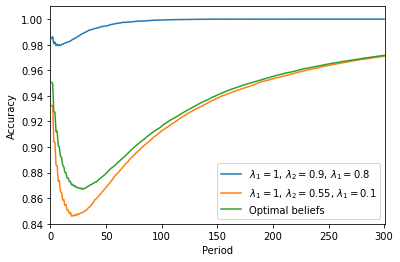

In [2]:
import random
from numpy import mean
import matplotlib.pyplot as plt


# define bayes' rule as function of the signal and the prior
def bayes(orange, prior):
    if orange == 1:
        return ( (2/3) * prior ) / ( (2/3) * prior + (1/3) * (1 - prior))
    if orange == 0:
        return ( (1/3) * prior ) / ( (1/3) * prior + (2/3) * (1 - prior))


# define a function that computes the simulated accuracy path for a given distribution of parameters
def accuracy(par1, par2, par3, num_teams, num_periods):
    acc_dct = dict()

    for team in range(1,num_teams+1):
        # initialize periods at 1
        period = 1
        # initialize priors to 1/2
        prior1 = 1/2
        prior2 = 1/2

        # draw an urn, which can be orange or not
        urn = random.choice([0,1])

        # draw a lambda for player 1 and a lambda from player 2 randomly
        lambda1 = random.choice([par1, par2, par3])
        lambda2 = random.choice([par1, par2, par3])

        # initialize paths of accuracies for the two players
        acc_lst = list()

        while period <= num_periods:
            if urn == 1:
                orange = random.choice([1, 1, 0])
            else:
                orange = random.choice([1, 0, 0])

            belief1 = lambda1 * bayes(orange, prior1) + (1-lambda1) * prior1
            belief2 = lambda2 * bayes(orange, prior2) + (1-lambda2) * prior2
            # append belief accuracy for the given period to the list
            acc_lst.append(1 - abs(belief1-belief2))
            # update period and priors
            period = period + 1
            prior1 = belief1
            prior2 = belief2

        acc_dct[team]=acc_lst

    # create a list of average accuracies in each period
    average_acc = list()
    for index in range(num_periods):
        # to compute average accuracy in period, first put all the teams' accuracies for that period in a list
        period_accs = list()
        # loop over the dictionary and add each team's accuracy for that period to the list above
        for k, v in acc_dct.items():
            period_accs.append(v[index])
        # add the mean across teams to the average accuracies list
        average_acc.append(mean(period_accs))

    # return acc_dct, average_acc
    return average_acc


# the code for generating the path of belief accuracies for a player who optimally takes into account the distribution of types
def optimal_accuracy(par1, par2, par3, num_teams, num_periods):
    acc_opt_dct = dict()

    for team in range(1,num_teams+1):
        # initialize periods at 1
        period = 1
        # initialize priors to 1/2
        prior = 1/2
        prior1 = 1/2
        prior2 = 1/2
        prior3 = 1/2

        # draw an urn, which can be orange or not
        urn = random.choice([0, 1])

        # draw a lambda for the non-optimal player randomly
        lamb = random.choice([par1, par2, par3])

        # initialize paths of accuracies for the two players
        acc_opt_lst = list()

        while period <= num_periods:
            if urn == 1:
                orange = random.choice([1, 1, 0])
            else:
                orange = random.choice([1, 0, 0])

            belief = lamb * bayes(orange, prior) + (1 - lamb) * prior
            belief1 = par1 * bayes(orange, prior1) + (1 - par1) * prior1
            belief2 = par2 * bayes(orange, prior2) + (1 - par2) * prior2
            belief3 = par3 * bayes(orange, prior3) + (1 - par3) * prior3
            belief_opt = (belief1 + belief2 + belief3)/3
            # append belief accuracy for the given period to the list
            acc_opt_lst.append(1 - abs(belief - belief_opt))
            # update period and priors
            period = period + 1
            prior = belief
            prior1 = belief1
            prior2 = belief2
            prior3 = belief3

        acc_opt_dct[team] = acc_opt_lst
    # create a list of average accuracies in each period
    average_acc = list()
    for index in range(num_periods):
        # to compute average accuracy in period, first put all the teams' accuracies for that period in a list
        period_accs = list()
        # loop over the dictionary and add each team's accuracy for that period to the list above
        for k, v in acc_opt_dct.items():
            period_accs.append(v[index])
        # add the mean across teams to the average accuracies list
        average_acc.append(mean(period_accs))

    # return acc_dct, average_acc
    return average_acc


# DRAW THE PATHS!

periods = list(range(1,301))
accuracies1 = accuracy(1, .9, .8, 5000, 300)
accuracies2 = accuracy(1, .55, .1, 5000, 300)
accuracies3 = optimal_accuracy(1, .55, .1, 5000, 300)

# print(accuracies1)
# print(accuracies2)
# print(accuracies3)

plt.plot(periods, accuracies1)
plt.plot(periods, accuracies2)
plt.plot(periods, accuracies3)
plt.axis([0, 301, 0.84, 1.01])
params = {'mathtext.default': 'regular' }
plt.xlabel('Period')
plt.ylabel('Accuracy')
plt.legend(['$\lambda_1=1$, $\lambda_2=0.9$, $\lambda_1=0.8$', '$\lambda_1=1$, $\lambda_2=0.55$, $\lambda_1=0.1$', 'Optimal beliefs'],
           loc='best')
plt.show()


# Figures 3, 5 and 10a

These figures plot average normalized guesses by treatment and player type (i.e., produce the empirical counterpart to Figure 1). The top row if figures in the resulting output uses data from the lab treatments, the middle row uses data from the MTurk treatments, and the bottom row uses data from the "within-long" treatment. 

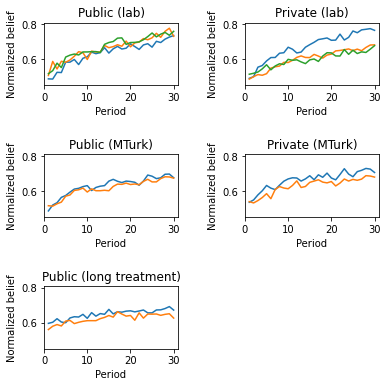

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

# load the data

data = pd.read_csv("data_ee.csv")

# create the normalized beliefs variables

# note second-order beliefs are saved as guess2 in the mturk treatments, so the averaging there needs to be done separately

data["guess_truth"] = data.apply(lambda row: row["guess"] if row["urn"] == 1 else 1-row["guess"], axis=1)
data["guess2_truth"] = data.apply(lambda row: row["guess2"] if row["urn"] == 1 else 1-row["guess2"], axis=1)

# average the beliefs by treatment, player type, and period

# note that type is meaningless in the mturk treatments, so the averaging there is done separately

data_mean = data.groupby(["mturk", "private", "lon", "gameperiod", "type"]).guess_truth.mean().reset_index()
mturk_mean = data.groupby(["mturk", "private", "lon", "gameperiod"]).guess_truth.mean().reset_index()
mturk2_mean = data.groupby(["mturk", "private", "lon", "gameperiod"]).guess2_truth.mean().reset_index()

# ensure that the data are sorted correctly

data_mean.sort_values(by=["mturk", "lon", "private", "type", "gameperiod"]).reset_index()
mturk_mean.sort_values(by=["mturk", "lon", "private", "gameperiod"]).reset_index()
mturk2_mean.sort_values(by=["mturk", "lon", "private", "gameperiod"]).reset_index()

# make the plots

plt.figure(figsize=(6, 6))
plt.subplot(3, 2, 1, title="Public (lab)")

plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==0) & (data_mean.type==1)])
plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==0) & (data_mean.type==2)])
plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==0) & (data_mean.type==3)])
plt.xlabel("Period")
plt.ylabel("Normalized belief")
plt.axis([0,31,.45,.81])

plt.subplot(3, 2, 2, title="Private (lab)")

plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==1) & (data_mean.type==1)])
plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==1) & (data_mean.type==2)])
plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==1) & (data_mean.type==3)])
plt.xlabel("Period")
plt.ylabel("Normalized belief")
plt.axis([0,31,.45,.81])

plt.subplot(3, 2, 3, title="Public (MTurk)")

plt.plot(range(1,31), mturk_mean.guess_truth[(mturk_mean.mturk==1) & (mturk_mean.lon==0) & (mturk_mean.private==0)])
plt.plot(range(1,31), mturk2_mean.guess2_truth[(mturk2_mean.mturk==1) & (mturk2_mean.lon==0) & (mturk2_mean.private==0)])
plt.xlabel("Period")
plt.ylabel("Normalized belief")
plt.axis([0,31,.45,.81])

plt.subplot(3, 2, 4, title="Private (MTurk)")

plt.plot(range(1,31), mturk_mean.guess_truth[(mturk_mean.mturk==1) & (mturk_mean.lon==0) & (mturk_mean.private==1)])
plt.plot(range(1,31), mturk2_mean.guess2_truth[(mturk2_mean.mturk==1) & (mturk2_mean.lon==0) & (mturk2_mean.private==1)])
plt.xlabel("Period")
plt.ylabel("Normalized belief")
plt.axis([0,31,.45,.81])

plt.subplot(3, 2, 5, title="Public (long treatment)")

plt.plot(range(1,31), mturk_mean.guess_truth[(mturk_mean.mturk==1) & (mturk_mean.lon==1) & (mturk_mean.private==0)])
plt.plot(range(1,31), mturk2_mean.guess2_truth[(mturk2_mean.mturk==1) & (mturk2_mean.lon==1) & (mturk2_mean.private==0)])
plt.xlabel("Period")
plt.ylabel("Normalized belief")
plt.axis([0,31,.45,.81])

plt.subplots_adjust(wspace=.5)
plt.subplots_adjust(hspace=1.1)

plt.show()

# Figure 4 

Figure 4 illustrates how the accuracy of higher-order beliefs evolves as more public or private information about the state of the world is received. For each group $g$ and period $t$, belief accuracy of Player $k\in{2,3}$ is defined as:

$$
Accuracy^k_{gt}=1-|a^k_{gt}-a^{k-1}_{g,t}|,
$$

To draw the figure, we average this variable across groups for each time period, treatment (private or public signals), and player type.


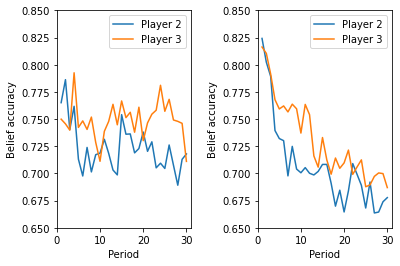

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

# load the data

data = pd.read_csv("data_ee.csv")

# break data up according to player type

data1 = data[(data.lon==0) & (data.mturk==0) & (data.type==1)]
data2 = data[(data.lon==0) & (data.mturk==0) & (data.type==2)]
data3 = data[(data.lon==0) & (data.mturk==0) & (data.type==3)]

# merge the three datasets by groups

data_merged=pd.merge(
    data1,
    data2,
    on=["ses", "round", "gameperiod", "group"]
)

data_merged=pd.merge(
    data_merged,
    data3,
    on=["ses", "round", "gameperiod", "group"]
)

# define the accuracy variables

data_merged["acc2"]=1-abs(data_merged["guess_x"]-data_merged["guess_y"])
data_merged["acc3"]=1-abs(data_merged["guess_y"]-data_merged["guess"])

# average accuracy by player type, period, and treatment 

acc2_mean = data_merged.groupby(["private", "gameperiod"]).acc2.mean().reset_index()
acc3_mean = data_merged.groupby(["private", "gameperiod"]).acc3.mean().reset_index()

# make the plots

plt.subplot(1, 2, 1)

plt.plot(range(1,31), acc2_mean[acc2_mean.private==0]["acc2"])
plt.plot(range(1,31), acc3_mean[acc2_mean.private==0]["acc3"])
plt.axis([0,31,.65,.85])
plt.xlabel("Period")
plt.ylabel("Belief accuracy")
plt.legend(['Player 2', 'Player 3'])

plt.subplot(1, 2, 2)

plt.plot(range(1,31), acc2_mean[acc2_mean.private==1]["acc2"])
plt.plot(range(1,31), acc3_mean[acc2_mean.private==1]["acc3"])
plt.axis([0,31,.65,.85])
plt.xlabel("Period")
plt.ylabel("Belief accuracy")
plt.legend(['Player 2', 'Player 3'])

plt.subplots_adjust(wspace=.5)

plt.show()